### Sequence memory
After the cue, replay the last ```pattern_length``` steps

In [29]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    r2_score,
    mean_squared_error
)

from echoes import ESNRegressor
import tasks
from utils import clean_df_param_names
from bioRNN.utils import remove_transient, make_scoring, cv_generator, clean_col_names

np.set_printoptions(suppress=True) #prevent numpy exponential 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
np.arange(80, 101, 5) * 0.01,


(array([0.8 , 0.85, 0.9 , 0.95, 1.  ]),)

In [32]:
trial_params = {           
    "task_name": 'seq_mem',
    'nr_of_trials': 2000,
    'pattern_length': 20,
    'low': 0.00001,
    'high': 1.,
    'train_size': 0.8,
}

(X_train, X_test), (y_train, y_test), trials_idx = tasks.create_trials(trial_params)
# np.concatenate((X_train, y_train), axis=1)

In [36]:
param_grid = dict(
    input_scaling = [.0001, .001],
    spectral_radius = [.9, .99]
)

cv = cv_generator(X_train, test_size=0.2)

n_transient = 200
scoring = make_scoring(
    {"r2": r2_score, "mse": mean_squared_error},
    n_transient=n_transient, 
    delete_fixation=True,
    greater_is_better=[True, False]    
)

In [37]:
grid = GridSearchCV(
    ESNRegressor(n_transient=n_transient),
    param_grid,
    cv=cv,
    scoring=scoring,
    refit="r2",
    n_jobs=-2,
).fit(X_train, y_train)

In [39]:
df = pd.DataFrame(grid.cv_results_)
df = clean_col_names(df)

(df
 .groupby(by=["input_scaling", "spectral_radius"])
 .mean()
 .style
#  .bar(subset=["r2"], color=["orange"])
#  .highlight_min(subset=["mse"], color="red")
 .background_gradient(subset=["r2"], cmap="Reds")
)

In [38]:
%%time

n_transient = int(trial_params["pattern_length"] * 5) # leave 3 trials out,
esn = ESNRegressor(
    n_reservoir=300,
#     random_state=2,
    n_transient=n_transient,
#     input_scaling=.1,
).fit(X_train, y_train)
esn.score(X_test, y_test)
y_pred = esn.predict(X_test)

CPU times: user 19.1 s, sys: 1.89 s, total: 21 s
Wall time: 2.91 s


In [39]:
r2 = remove_fixation(remove_transient(n_transient=n_transient)(r2_score))
mse = remove_fixation(remove_transient(n_transient=n_transient)(mean_squared_error))

In [40]:
# mask = y_test != 0
print(r2(y_test, y_pred))
print(mse(y_test, y_pred))
# print(r2_score(y_test[mask][20:], y_pred[mask][20:]))

# plt.figure(figsize=(20, 5))
# plt.plot(y_test[20: 200])#1000: 1200])
# plt.plot(y_pred[20: 200])#1000: 1200])
# plt.figure(figsize=(20, 5))
# plt.plot(y_test[mask][: 100])
# plt.plot(y_pred[mask][: 100])

0.8799950319390782
0.010043741715589034


In [9]:
y_pred.shape

(4200, 1)

In [10]:
(y_test != 0).sum()

2000

In [ ]:
5*

In [8]:
results = pd.read_csv("/media/fabrizio/91114856-a405-4086-bfbb-6c0bb5854f13/fdamicel/data/icns/bioRNN/sequence-memory-cue/gridsearch_hyperparams/macaque_patlen10.csv")

In [12]:
from pandas.plotting import table

(results
 .groupby(by=["W", "input_scaling", "spectral_radius", "leak_rate"])
 .mean()
 .style
#  .bar(subset=["r2"], color=["orange"])
#  .highlight_min(subset=["mse"], color="red")
 .background_gradient(subset=["r2"], cmap="Reds")
)

In [13]:
results.input_scaling[0]

0    1e-05
0    1e-05
Name: input_scaling, dtype: object

In [84]:
results.drop(
    inplace=True,
    columns=[
        c for c in result.columns 
        if any((
            c.startswith(("split0", "std_", "rank_")),            
            c.endswith("_time"),
            c == "params"
        ))
    ]
)
                                                         
#results.drop(columns=["params"], inplace=True)
results.rename({"mean_test_r2": "r2", "mean_test_mse": "mse"}, axis="columns", inplace=True)

,W,spectral_radius,r2,mse
0,W_bio,0.80,0.692740,-0.031956
1,W_bio,0.84,0.732219,-0.027850
2,W_bio,0.88,0.642027,-0.037230
3,W_bio,0.92,0.720004,-0.029120
4,W_bio,0.96,0.708207,-0.030347


In [37]:
results = results[results.columns[:5]]

In [38]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,W
0,0.086999,0.0,0.007874,0.0,W_bio
1,0.055945,0.0,0.009013,0.0,W_bio
2,0.049506,0.0,0.013917,0.0,W_bio
3,0.035994,0.0,0.008988,0.0,W_bio
4,0.042038,0.0,0.009750,0.0,W_bio
...,...,...,...,...,...
50,0.048560,0.0,0.006530,0.0,W_full
51,0.049356,0.0,0.010134,0.0,W_full
52,0.031737,0.0,0.012413,0.0,W_full
53,0.041983,0.0,0.007557,0.0,W_full


In [32]:
results.drop(columns=['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
                     'params', 'split0_test_r2', 'std_test_r2', 'rank_test_r2', 'split0_test_mse',
                     'std_test_mse',], inplace=True)

In [33]:
results

,W,spectral_radius,mean_test_r2,mean_test_mse,rank_test_mse
0,W_bio,0.80,0.741329,-0.026833,47
1,W_bio,0.84,0.636944,-0.037661,55
2,W_bio,0.88,0.681682,-0.033020,54
3,W_bio,0.92,0.684865,-0.032690,53
4,W_bio,0.96,0.693306,-0.031814,52
...,...,...,...,...,...
50,W_full,1.04,0.911040,-0.009155,33
51,W_full,1.08,0.917052,-0.008536,28
52,W_full,1.12,0.927054,-0.007507,20
53,W_full,1.16,0.934365,-0.006754,12


In [19]:
((-results_df.mean_test_mse).argmin(),
 results_df.mean_test_r2.argmax(),
)

(3, 3)

In [21]:
((-results_df.mean_test_mse).min(),
 results_df.mean_test_r2.max(),
)

(1.3934758653620502e-10, 0.999999998602764)

0.8886970401107783


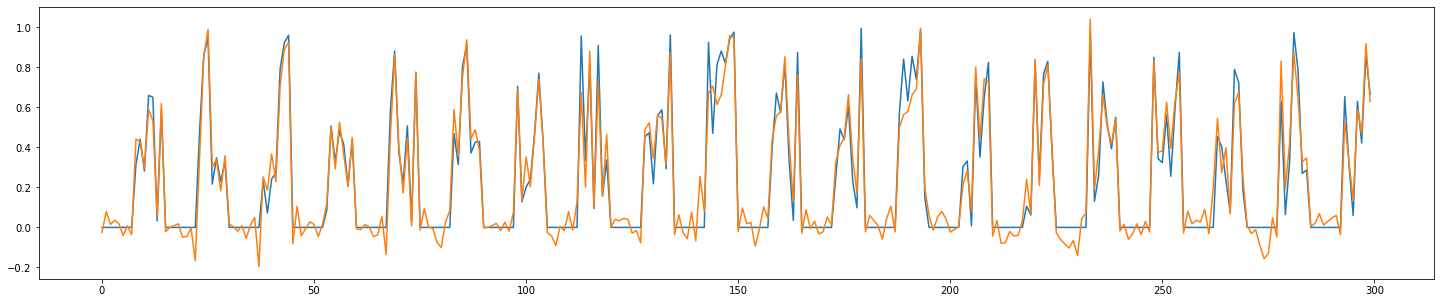

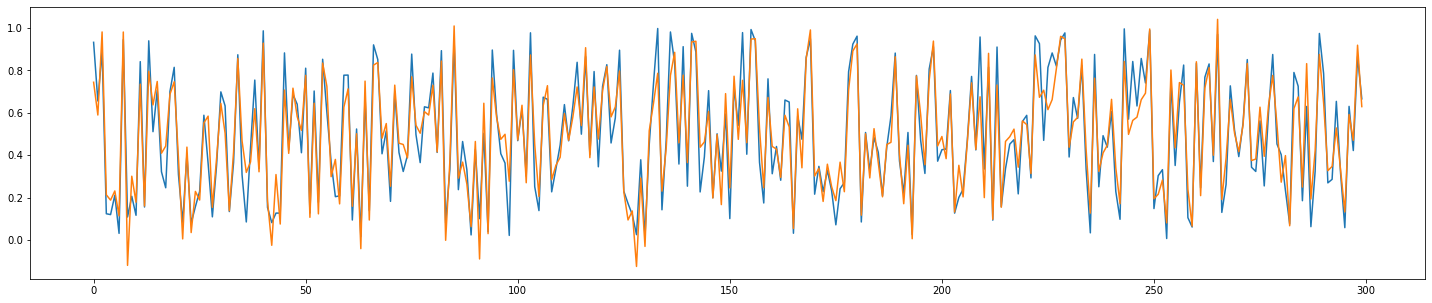

In [133]:
mask = y_test != 0
print(r2_score(y_test[mask][20:], y_pred[mask][20:]))

plt.figure(figsize=(25, 5))
plt.plot(y_test[-300:])#1000: 1200])
plt.plot(y_pred[-300:])#1000: 1200])
plt.figure(figsize=(25, 5))
plt.plot(y_test[mask][-300:])
plt.plot(y_pred[mask][-300:])

In [136]:
results_df = clean_df_param_names(pd.DataFrame(grid.cv_results_))
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,input_scaling,n_reservoir,spectral_radius,params,split0_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_test_r2trimmed,mean_test_r2trimmed,std_test_r2trimmed,rank_test_r2trimmed,split0_test_mse,mean_test_mse,std_test_mse,rank_test_mse
0,1.455623,0.0,0.206524,0.0,1e-05,100,0.8,"{'input_scaling': 1e-05, 'n_reservoir': 100, '...",-4.827665e+11,-4.827665e+11,0.0,18,-3.152448,-3.152448,0.0,17,-4.929513e+10,-4.929513e+10,0.0,18
1,1.463217,0.0,0.199540,0.0,1e-05,100,0.9,"{'input_scaling': 1e-05, 'n_reservoir': 100, '...",-4.321800e+10,-4.321800e+10,0.0,17,-150.402768,-150.402768,0.0,18,-4.412977e+09,-4.412977e+09,0.0,17
2,1.464682,0.0,0.196933,0.0,1e-05,100,99,"{'input_scaling': 1e-05, 'n_reservoir': 100, '...",4.004417e-01,4.004417e-01,0.0,7,0.400560,0.400560,0.0,15,-6.122071e-02,-6.122071e-02,0.0,7
3,0.764193,0.0,0.199020,0.0,0.0001,100,0.8,"{'input_scaling': 0.0001, 'n_reservoir': 100, ...",-5.030632e+09,-5.030632e+09,0.0,16,0.831666,0.831666,0.0,9,-5.136762e+08,-5.136762e+08,0.0,16
4,1.445572,0.0,0.123422,0.0,0.0001,100,0.9,"{'input_scaling': 0.0001, 'n_reservoir': 100, ...",-2.532675e+08,-2.532675e+08,0.0,15,0.668139,0.668139,0.0,10,-2.586107e+07,-2.586107e+07,0.0,15
